**Helpful Links: Where the Data Lives**

Open Academic Society: [Project Page](https://www.openacademic.ai/oag/)

Microsoft Research: [MS Academic Graph](https://www.microsoft.com/en-us/research/project/microsoft-academic-graph/)

In [1]:
import pandas as pd

In [2]:
model_df = pd.read_json('data/mag_papers_0/mag_subset.txt', lines=True)

In [3]:
# filter out non-English articles
# keep abstract, authors, fos, keywords, year, title

model_df = model_df[model_df.lang == 'en'].drop(['doc_type', 'doi', 'id', 'issue', 'lang', 'n_citation', 'page_end', 
                            'page_start', 'publisher', 'references', 'url', 'venue', 'volume'], axis=1)

model_df.shape

(5167, 6)

In [ ]:
unique_fos = sorted(list({ feature
                          for paper_row in model_df.fos.fillna('0')
                          for feature in paper_row }))

In [20]:
def feature_array(x, var, unique_array):
    row_dict = {}
    for i in x.index:
        var_dict = {}
        
        for j in range(len(unique_array)):
            if type(x[i]) is list:
                if unique_array[j] in x[i]:
                    var_dict.update({var + '_' + unique_array[j]: 1})
                else:
                    var_dict.update({var + '_' + unique_array[j]: 0})
            else:    
                if unique_array[j] == str(x[i]):
                    var_dict.update({var + '_' + unique_array[j]: 1})
                else:
                    var_dict.update({var + '_' + unique_array[j]: 0})
        
        row_dict.update({i : var_dict})
    
    feature_df = pd.DataFrame.from_dict(row_dict, dtype='str').T
    
    return feature_df

We will start with a simple example of building a recommender with just a few fields, building sparse arrays of available features to calculate for the Jaccard similary between papers. We will see if reasonably similar papers can be found in a timely manner.

In [ ]:
%time fos_features = feature_array(model_df['fos'], 'fos', unique_fos)

# (2) engineering our current features, pipe, outcome

In [ ]:
year_features.shape[1] + fos_features.shape[1]

Okay, we remember than numerical features broadly distributed across a dataset can unnecessarily increase the size of our feature space. Let's wrangle this in first.

In [4]:
model_df['year'].tail()

9988    2012
9994    2007
9997    2008
9998    2001
9999    2015
Name: year, dtype: int64

In [5]:
print("Year spread: ", model_df['year'].min()," - ", model_df['year'].max())
print("Quantile spread:\n", model_df['year'].quantile([0.25, 0.5, 0.75]))

Year spread:  1831  -  2017
Quantile spread:
 0.25    1990.0
0.50    2005.0
0.75    2012.0
Name: year, dtype: float64


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [8]:
%matplotlib inline

Text(0,0.5,'Occurrence')

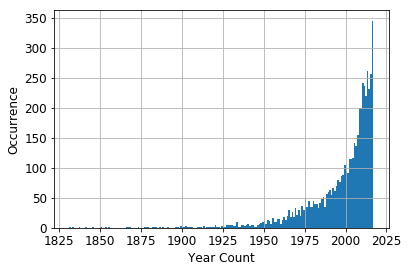

In [9]:
# plot years to see the distribution
fig, ax = plt.subplots()
model_df['year'].hist(ax=ax, bins= model_df['year'].max() - model_df['year'].min())
ax.tick_params(labelsize=12)
ax.set_xlabel('Year Count', fontsize=12)
ax.set_ylabel('Occurrence', fontsize=12)

We can see from the uneven distribution that this is an excellent candidate for binning and dummy coding. Lucky for us, pandas can do all these things using built-in functions. Our results will be easy to interpret.

## years: binning + dummy coding

In [10]:
# we'll base our bins on the range of the variable, rather than the unique number of features
model_df['year'].max() - model_df['year'].min()

186

In [11]:
# insert binning here (by 10 years)
bins = int(round((model_df['year'].max() - model_df['year'].min()) / 10))

temp_df = pd.DataFrame(index = model_df.index)
temp_df['yearBinned'] = pd.cut(model_df['year'].tolist(), bins, precision = 0)

In [12]:
# now we only have as many bins as we created(grouping together by 10 years)
print('We have reduced from', len(model_df['year'].unique()),
      'to', len(temp_df['yearBinned'].values.unique()), 'features representing the year.')

We have reduced from 137 to 19 features representing the year.


In [13]:
binned_yrs = pd.get_dummies(temp_df['yearBinned'])
binned_yrs.head()

,"(1831.0, 1841.0]","(1841.0, 1851.0]","(1851.0, 1860.0]","(1860.0, 1870.0]","(1870.0, 1880.0]","(1880.0, 1890.0]","(1890.0, 1900.0]","(1900.0, 1909.0]","(1909.0, 1919.0]","(1919.0, 1929.0]","(1929.0, 1939.0]","(1939.0, 1948.0]","(1948.0, 1958.0]","(1958.0, 1968.0]","(1968.0, 1978.0]","(1978.0, 1988.0]","(1988.0, 1997.0]","(1997.0, 2007.0]","(2007.0, 2017.0]"
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [14]:
binned_yrs.columns.categories

IntervalIndex([(1831.0, 1841.0], (1841.0, 1851.0], (1851.0, 1860.0], (1860.0, 1870.0], (1870.0, 1880.0] ... (1968.0, 1978.0], (1978.0, 1988.0], (1988.0, 1997.0], (1997.0, 2007.0], (2007.0, 2017.0]]
              closed='right',
              dtype='interval[float64]')

Text(0,0.5,'Counts')

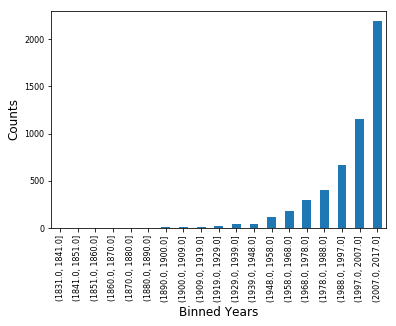

In [15]:
# let's look at the new distribution
fig, ax = plt.subplots()
binned_yrs.sum().plot.bar(ax = ax)
ax.tick_params(labelsize=8)
ax.set_xlabel('Binned Years', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

We have preserved the underlying distribution of the original variable through binning by decades. If we desired to use a method that would benefit from a different distribution, we could alter our binning choices to change how this variable presents itself to the model. Since we are using a cosine similarity, this is fine.

Let's move on to the next feature we originally included in our model.

## [TODO] fields of study: One-Hot Encoding > check this...

This feature contributed significantly to the original model's size and processing time. We we will aim to reduce these. 

In [16]:
# need to fill in "NaN" for sklearn
fos_df = model_df.fillna('None')

In [17]:
fos_df['fos'].head()

0    [Electronic engineering, Computer hardware, En...
1        [Biology, Virology, Immunology, Microbiology]
2                                                 None
5                                                 None
7           [Medicine, Pathology, Gynecology, Surgery]
Name: fos, dtype: object

Let's leverage work we have already done. We have a sparse array of parsed field of study fields. The names for the feature space take up the most room. We'll pare this down by taking advantage of sklearn's One-Hot Encoder.

In [18]:
fos_features.head(2)

NameError: name 'fos_features' is not defined

In [ ]:
m = len(unique_fos)
m

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(n_values = m)

In [ ]:
f = enc.fit(fos_features)

In [ ]:
show_mem_usage()

In [ ]:
#fos_1he = f.transform(fos_features).toarray()

In [ ]:
fos_1he.shape

In [ ]:
sum(fos_1he[1])

In [ ]:
# We can see how this will make a difference in the future by looking at the size of each
from sys import getsizeof

print('Our pandas Series, in bytes: ', getsizeof(fos_features))
print('Our hashed numpy array, in bytes: ', getsizeof(fos_1he))

Putting it back together, we'll pipe our features together and re-run our recommender to see if we have improved results. Since we are starting to use sklearn, we'll take advantage of their cosine similarity function, reducing the computational time by only focusing on one item at a time.

In [ ]:
binned_yrs.shape[1] + fos_1he.shape[1]

In [ ]:
# now looking at 5167 x  9442 array for our feature space

%time second_features = np.append(fos_1he, binned_yrs.values, axis = 1)

second_size = getsizeof(second_features)

print('Size of second feature array, in bytes: ', second_size)

In [ ]:
print("The power of feature engineering saves us, in bytes: ", first_size - second_size)

In [ ]:
from sklearn.metrics.pairwise import linear_kernel

def piped_collab_filter(features_matrix, index, top_n):
                
    item_similarities = linear_kernel(features_matrix[index:index+1], features_matrix).flatten() 
    related_indices = [i for i in item_similarities.argsort()[::-1] if i != index]

    return [(index, item_similarities[index]) for index in related_indices][0:top_n]

def paper_recommender(items_df, paper_index, top_n):
    print('Based on the paper: \nindex = ', paper_index)
    print(model_df.iloc[paper_index])
    top_results = piped_collab_filter(items_df, paper_index, top_n)
    print('\nTop three results: ') 
    order = 1
    for i in range(len(top_results)):
        print(order,'. Paper index = ', top_results[i][0])
        print('Similarity score: ', top_results[i][1])
        print(model_df.iloc[i], '\n')
        if order < 5: order += 1

In [ ]:
paper_recommender(binned_yrs, 2, 3)

# (3) a few more features, pipe, outcome

## abstract: stopwords, frequency based filtering (tf-idf?)

In [ ]:
# need to fill in NaN for sklearn
abstract_df = model_df.fillna('None')

# abstract: stopwords, frequency based filtering (tf-idf?)
abstract_df['abstract'].head()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
X_abstract = vectorizer.fit_transform(abstract_df['abstract'])

X_abstract

In [ ]:
print("n_samples: %d, n_features: %d" % X_abstract.shape)

## authors: One-Hot Encoding using sklearn DictVectorizer()

In [ ]:
authors_df = pd.DataFrame(model_df.authors)
authors_df.head()

In [ ]:
import json

In [ ]:
type(authors_df.authors[5][0])

In [ ]:
authors_list = []

for row in authors_df.itertuples():
    # create a dictionary from each Series index
    if type(row.authors) is list:
        # add these keys + values to our running dictionary    
        y = dict.fromkeys(row.authors[0].values(), row.Index)
        authors_list.append(y)

In [ ]:
authors_list[0:5]

In [ ]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)
D = authors_list
X = v.fit_transform(D)

In [ ]:
X[0:5]

In [ ]:
len(authors_dict)

Let's combine these new features with our last engineered features to see if we are on the right track.

In [ ]:
binned_yrs.shape[1] + fos_1he.shape[1]

# now looking at 5167 x  9442 array for our feature space

%time second_features = np.append(fos_1he, binned_yrs.values, axis = 1)

second_size = getsizeof(second_features)

print('Size of second feature array, in bytes: ', second_size)

print("The power of feature engineering saves us, in bytes: ", first_size - second_size)

paper_recommender(binned_yrs, 2, 3)

# (4) a few more...does that help? results? performance?
### no? okay. return to best case. all about experimentation.

## titles: noun phrases + chunking

In [ ]:
model_df['title'].head()

## keywords: stemming?

In [ ]:
model_df['keywords'].head()

## summary ##

As you can see, building models for machine learning is easy. Building *good* models for the useful outcomes takes time and work. We hiked through the messy processes here of examining a collection of possible variables and experimenting with different feature engineering methods to achieve better results. We define better here as not just good outcomes from our training and testing, but also reducing the size of the model and time it takes us to iterate over different experiments.

**Citations**

Jie Tang, Jing Zhang, Limin Yao, Juanzi Li, Li Zhang, and Zhong Su. ArnetMiner: Extraction and Mining of Academic Social Networks. In Proceedings of the Fourteenth ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (SIGKDD’2008). pp.990-998. [PDF](http://keg.cs.tsinghua.edu.cn/jietang/publications/KDD08-Tang-et-al-ArnetMiner.pdf) [Slides](http://keg.cs.tsinghua.edu.cn/jietang/publications/KDD08-Tang-et-al-Arnetminer.ppt) [System](http://aminer.org/) [API](http://aminer.org/RESTful_service)

Arnab Sinha, Zhihong Shen, Yang Song, Hao Ma, Darrin Eide, Bo-June (Paul) Hsu, and Kuansan Wang. 2015. An Overview of Microsoft Academic Service (MAS) and Applications. In Proceedings of the 24th International Conference on World Wide Web (WWW ’15 Companion). ACM, New York, NY, USA, 243-246. [PDF](https://www.microsoft.com/en-us/research/publication/an-overview-of-microsoft-academic-service-mas-and-applications-2/) [System](https://academic.microsoft.com/) [API](https://docs.microsoft.com/en-us/azure/cognitive-services/academic-knowledge/home)

http://www.markhneedham.com/blog/2016/07/27/scitkit-learn-tfidf-and-cosine-similarity-for-computer-science-papers/